In [1]:
# Importing libraries
try:
  # This command only in Colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from math import ceil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Getting the data files and unzipping 
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
!unzip cats_and_dogs.zip &> /dev/null

--2020-11-26 08:16:26--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip       [       <=>          ]  67.43M  50.0MB/s    in 1.3s    

2020-11-26 08:16:27 (50.0 MB/s) - ‘cats_and_dogs.zip’ saved [70702765]



In [3]:
# Removing the zip file
!rm cats_and_dogs.zip
!rm -rf __MACOSX

In [4]:
# Handling the data
def handle_data():
  # Directory specification
  PATH = 'cats_and_dogs'
  train_dir = os.path.join(PATH, 'train')
  validation_dir = os.path.join(PATH, 'validation')
  test_dir = os.path.join(PATH, 'test')

  # Get number of files in each directory. The train and validation directories each have the subdirectories "dogs" and "cats".
  total_train = sum([len(files) for r, d, files in os.walk(train_dir)])-1
  total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])-1
  total_test = len(os.listdir(test_dir))-1
  print('Number of images used for training:', total_train) 
  print('Number of images used for validation:', total_val)
  print('Number of images used for testing:', total_test)

  # Variables for pre-processing and training
  batch_size = 128
  epochs = 15
  IMG_HEIGHT = 150
  IMG_WIDTH = 150

  # Using ImageDataGenerator to read the images, converting them into floating point tensors and mormalizing them
  train_image_generator      = ImageDataGenerator(rescale=1./255)
  validation_image_generator = ImageDataGenerator(rescale=1./255)
  test_image_generator       = ImageDataGenerator(rescale=1./255)

  # Datasets created in specified format
  train_data_gen = train_image_generator.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size, class_mode='binary')

  val_data_gen   = validation_image_generator.flow_from_directory(validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size, class_mode='binary')

  test_data_gen  = test_image_generator.flow_from_directory(PATH, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size, classes=['test'], shuffle=False)

  return batch_size, epochs, IMG_HEIGHT, IMG_WIDTH, train_data_gen, val_data_gen, test_data_gen, train_dir, total_train, total_val, total_test

In [5]:
# Data Augmentation to avoid overfitting
def data_augment(train_dir):
  train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, fill_mode="nearest")

  train_data_gen_da = train_image_generator.flow_from_directory(batch_size=batch_size, directory=train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')

  augmented_images = [train_data_gen_da[0][0][0] for i in range(5)]

  return train_data_gen_da, augmented_images 

In [6]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

In [7]:
# Building the model
def create_model(IMG_HEIGHT,IMG_WIDTH):
  model = Sequential()
  model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # Compiling model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  print(model.summary())
  return model

In [8]:
# Training the model
def train_model(model, batch_size, train_data_gen_da, total_train, total_val):
  # Steps for training and validation
  train_steps = int(ceil(1. * total_train / batch_size))
  val_steps   = int(ceil(1. * total_val / batch_size))
  history = model.fit(train_data_gen_da, steps_per_epoch=train_steps, validation_data=val_data_gen, validation_steps=val_steps, epochs=epochs)
  return history

In [9]:
# Evaluating the model
def evaluate_model(history, epochs, test_data_gen):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='Lower Right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='Upper Right')
  plt.title('Training and Validation Loss')
  plt.show()

In [10]:
def test_model(model, test_data_gen):

  probabilities = model.predict(test_data_gen).flatten()
  print("Probabilities for cat or dog : ",  probabilities)

  answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
              1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
              1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
              1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
              0, 0, 0, 0, 0, 0]

  correct = 0

  for probability, answer in zip(probabilities, answers):
    if round(probability) == answer:
      correct +=1

  percentage_identified = (correct / len(answers))

  passed_challenge = percentage_identified > 0.63

  print(f"Your model correctly identified {round(percentage_identified, 2)*100}% of the images of cats and dogs.")

  if passed_challenge:
    print("You passed the challenge!")
  else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Number of images used for training: 2000
Number of images used for validation: 1000
Number of images used for testing: 50
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
Found 2000 images belonging to 2 classes.
Printing sample training images : 


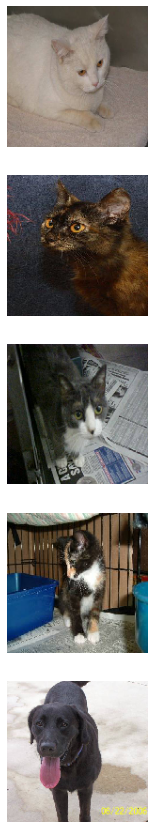

Printing some augmented data : 


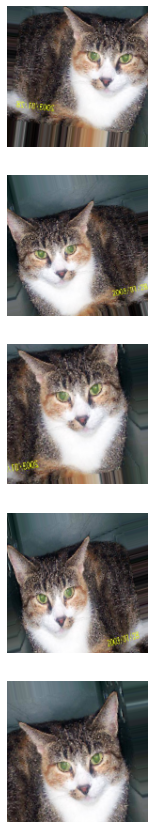

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'Lower Right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Unrecognized location 'Upper Right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


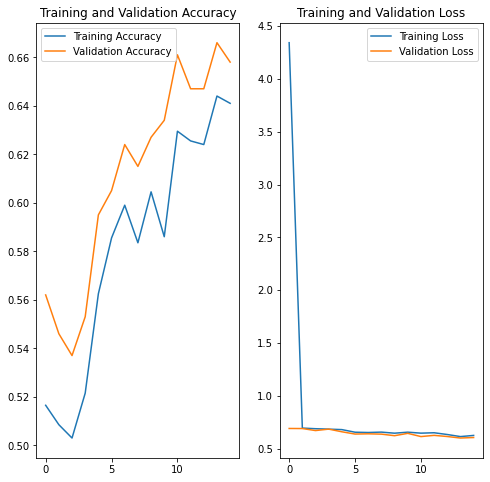

Testing the model now....
Probabilities for cat or dog :  [0.54728794 0.42537078 0.15031263 0.5182838  0.28711104 0.2617219
 0.4417684  0.36033207 0.52388334 0.80807346 0.38147086 0.41971537
 0.22714196 0.27071235 0.3236638  0.5856526  0.5974155  0.6468418
 0.36198303 0.40406385 0.19984621 0.35141554 0.29709545 0.20836075
 0.54446757 0.42009106 0.88031125 0.3986137  0.3899224  0.5184752
 0.41683903 0.2928988  0.5277322  0.99979705 0.3084739  0.5381811
 0.9964224  0.7025144  0.3059724  0.3061916  0.37723106 0.46361145
 0.76047033 0.6046349  0.34742916 0.35615057 0.4165816  0.29772973
 0.32417884 0.21789488]
Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!


In [11]:
if __name__ == '__main__':
  batch_size, epochs, IMG_HEIGHT, IMG_WIDTH, train_data_gen, val_data_gen, test_data_gen, train_dir, total_train, total_val, total_test = handle_data()
  train_data_gen_da, augmented_images = data_augment(train_dir)

  print("Printing sample training images : ")
  sample_training_images, _ = next(train_data_gen)
  plotImages(sample_training_images[:5])
  
  print("Printing some augmented data : ")
  plotImages(augmented_images)
  
  model = create_model(IMG_HEIGHT,IMG_WIDTH)
  
  print("Training the model now....")
  history = train_model(model, batch_size, train_data_gen_da, total_train, total_val)

  print("Evaluating the model now....")
  evaluate_model(history, epochs, test_data_gen)

  print("Testing the model now....")
  test_model(model, test_data_gen)